<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/FeatureSubsetBinaryClassifers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data
/content/drive/.shortcut-targets-by-id/1viBwZM7BIiD8O4LeU-9UQXyV82oTWqh6/ConfidentMachineTranslation/flores
'=0.5.0'			 FeatureSubsetBinaryClassifers.ipynb
 analysis			 FLORES.ipynb
 Analysis			 LanguageAnalysis.ipynb
 backward_models		 language_models
 BoostedBinaryClassifers.ipynb	 LM_Thresholding.ipynb
 checkpoints			 NCD_Analysis.ipynb
 ClassificationDataset		 NNClassification.ipynb
 configs			 noisychannel
 data				 NoisyChannel.ipynb
 

In [2]:
pip install fairseq sacrebleu sentencepiece

     |████████████████████████████████| 307kB 2.8MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 7.6MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2021146 sha256=1ca91ccfc77ebec8951b550edb348265d9b29a2e2e68aabcfdf361e404606691
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [3]:
# prints how much GPU RAM is available
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=7adfac5c19ac21ab7a591250457d54fcc699fb6523e01f23aa71b9619a8fa07c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 159.5 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
import numpy as np
from itertools import zip_longest
from sklearn.svm import SVC


class CustomEnsembleClassifier:
    def __init__(self, clfs):
        self.classifiers = clfs
    
    def predict(self, X):
        probabilities = None
        for clf in self.classifiers:
            if probabilities is None:
                probabilities = clf.predict_proba(X)
            else:
                probabilities += clf.predict_proba(X)
        return np.argmax(np.array(probabilities), axis=1)



def printDatasetClassProp(Y): 
    classes = {}
    total = len(Y)
    for i in Y:
        if i in classes:
            classes[i] += 1
        else:
            classes[i] = 1
    
    for cls in classes:
        print("Proportion in class " + str(cls) + " = " + str(classes[cls]/total))

def datasetReader(featureFile, labelFile):
    files = [featureFile, labelFile]

    X = []
    Y = []

    for lines in zip_longest(*files, fillvalue=''):
        currX, currY = lines[0], float(lines[1].strip("\n"))
        Xarr = []
        features = currX.split()
        for feature in features:
            Xarr.append(float(feature.strip(",").strip("\n")))
        X.append(Xarr)
        Y.append(currY)    
    return np.array(X), np.array(Y)


def computeSimilarity(o1, o2):
    total = len(o1)
    same = 0
    for i in range(len(o1)):
        if o1[i] == o2[i]:
            same += 1
    print(same/total)


def trainMLPClassifier(X, Y, verbose=True):
    if verbose:
        print("Training MLP Classifier")
    clf = MLPClassifier(hidden_layer_sizes=(64, 256, 512, 256, 64), random_state=42,
                        max_iter=200, learning_rate='adaptive', learning_rate_init=0.0005, activation='relu')
    clf.fit(X, Y)
    return clf

def trainKNeighborsClassifier(X, Y, verbose=True):
    if verbose:
        print("Training KNeighbors Classifier")
    clf = KNeighborsClassifier(100)
    clf.fit(X, Y)
    return clf

def trainGaussianProcessClassifier(X, Y, verbose=True):
    if verbose:
        print("Training Gaussian Process Classifier")
    length_scale = [1 for i in range(len(X[0]))]
    clf = GaussianProcessClassifier(1.0 * RBF(length_scale), warm_start=True, random_state=42, n_jobs=-1)
    clf.fit(X, Y)
    return clf

def trainCustomEnsemble(X, Y, maxDepth=8, estimators=100, verbose=True):
    if verbose:
        print("Training custom ensemble")
    rf = RandomForestClassifier(max_depth=maxDepth, random_state=42)
    grad = GradientBoostingClassifier(random_state=42)
    ada = AdaBoostClassifier(n_estimators=estimators, random_state=42)
    # dl = MLPClassifier(hidden_layer_sizes=(100), random_state=1, max_iter=200)
    # kn = KNeighborsClassifier(100)

    classifiers = [rf, grad, ada]

    for clf in classifiers:
        clf.fit(X, Y)

    return CustomEnsembleClassifier(classifiers)
    

def trainEnsembleClassifier(X, Y, maxDepth=8, estimators=100, verbose=True):
    if verbose:
        print("Training an ensemble of Random Forest and Gradient Boosting Classifiers")

    estimators = [
     ('rf', RandomForestClassifier(max_depth=maxDepth, random_state=42)),
     ('grad', GradientBoostingClassifier(random_state=42))]
    clf = StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier(n_estimators=50, random_state=42))
    clf.fit(X, Y)
    return clf


def trainRandomForestClassifier(X, Y, maxDepth=8, verbose=True):
    if verbose:
        print("Training Random Forest classifier")
    clf = RandomForestClassifier(max_depth=maxDepth, random_state=42)
    clf.fit(X, Y)
    return clf

def trainAdaBoostClassifier(X, Y, estimators=100, verbose=True):
    if verbose:
        print("Training AdaBoosted Decision Tree classifier")
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=estimators, random_state=42)
    clf.fit(X, Y)
    return clf

def trainGradientBoostingClassifier(X, Y, verbose=True):
    if verbose:
        print("Training Graident Boosted classifier")
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(X, Y)
    return clf

def trainSVM(X, Y, verbose=True):
    if verbose:
        print("Training SVM classifier")
    clf = SVC(gamma='auto')
    clf.fit(X, Y)
    return clf

def calculateAccuracy(predictedClasses, groundTruth):
    correct_accepted = 0
    total_accepted = 0

    correct_rejected = 0
    total_rejected = 0

    for i in range(len(predictedClasses)):
        if groundTruth[i] == 1:
            total_accepted += 1
            if predictedClasses[i] == groundTruth[i]:
                correct_accepted += 1
        else:
            total_rejected += 1
            if predictedClasses[i] == groundTruth[i]:
                correct_rejected += 1


    print("Correctly accepted = " + str(correct_accepted/total_accepted))
    print("Incorrectly rejected = " + str(1 - correct_accepted/total_accepted))
    print("Correctly rejected = " + str(correct_rejected/total_rejected))
    print("Incorrectly accepted = " + str(1 - correct_rejected/total_rejected))

    print("Total Accuracy = " + str((correct_accepted + correct_rejected)/(total_accepted + total_rejected)))

(2559, 23)
(2559, 23)
(2835, 23)
TRAIN SET CLASS PROPORTIONS:
Proportion in class 0.0 = 0.8014849550605705
Proportion in class 1.0 = 0.19851504493942945
TEST SET CLASS PROPORTIONS
Proportion in class 1.0 = 0.2536155202821869
Proportion in class 0.0 = 0.7463844797178131

(2559, 1)
(2835, 1)
#################################################
Training Random Forest classifier
TRAIN ACCURACY
Correctly accepted = 0.34448818897637795
Incorrectly rejected = 0.655511811023622
Correctly rejected = 0.98488542174549
Incorrectly accepted = 0.015114578254510014
Total Accuracy = 0.8577569363032435
TEST ACCURACY
Correctly accepted = 0.2141863699582754
Incorrectly rejected = 0.7858136300417247
Correctly rejected = 0.9428166351606805
Incorrectly accepted = 0.05718336483931952
Total Accuracy = 0.7580246913580246
#################################################
TRAIN SET
2559


IndexError: ignored

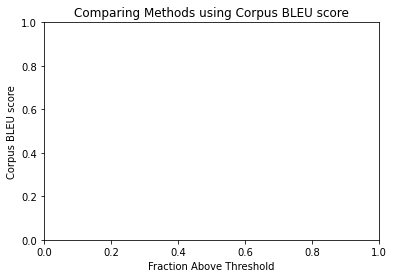

In [38]:
##make precision graphs
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random

class Translation:
    def __init__(self, original, reference, translation, score, features):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.features = features

def compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations):
    acceptedScore = 0 if len(acceptedTranslations) == 0 else sum([translation.score for translation in acceptedTranslations])/len(acceptedTranslations)
    
    rejectedScore = 0 if len(rejectedTranslations) == 0 else sum([translation.score for translation in rejectedTranslations])/len(rejectedTranslations)

    return rejectedScore, acceptedScore

def compute_excluded_included_score (acceptedTranslations, rejectedTranslations):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")
    
    for translation in acceptedTranslations:
        temporary_reference_inclusion.write(translation.reference)
        temporary_output_inclusion.write(translation.translation)

    for translation in rejectedTranslations:
        temporary_reference_exclusion.write(translation.reference)
        temporary_output_exclusion.write(translation.translation)

    
    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
    !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

    temporary_inclusion_result = open("analysis/inclusion_result.txt")
    temporary_exclusion_result = open("analysis/exclusion_result.txt")
    if (len([line for line in temporary_inclusion_result]) > 1 and len([line for line in temporary_inclusion_result][1].split(" ")[2] > 2)):
      inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    if (len([line for line in temporary_exclusion_result]) > 1 and len([line for line in temporary_exclusion_result][1].split(" ")[2] > 2)):
      exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


def readTranslations(sentenceFile, featureArray):
    translations = []
    temp = []
    index = 0
    for line in sentenceFile:
        if len(temp) < 3:
            temp.append(line)
        else:
            score = float(line.strip("\n"))
            translations.append(Translation(temp[0], temp[1], temp[2], score, featureArray[index]))
            index += 1
            temp = []
    
    return translations

def getTrainTestSets(trainTranslations, testTranslations, threshold_train, threshold_test, avgLogProb):
    trainFeatures = []
    trainY = []
    testFeatures = []
    testY = []

    for translation in trainTranslations:
        trainFeatures.append(translation.features)
        if avgLogProb:
            if translation.features[0] < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
        else:
            if translation.score < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
    
    for translation in testTranslations:
        testFeatures.append(translation.features)
        if translation.score < threshold_test:
            testY.append(0)
        else:
            testY.append(1)

    return trainFeatures, trainY, testFeatures, testY

# featuresUsed = [0, 5, 6, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
# featuresUsed = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] ##All
avgLogProb = [False, False, False, False]
featuresUsed = [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
# featuresUsed = [10, 11, 12]
featureSubsets = [[10], #just baseline Forward Model score [P(T|S)]
                  [10, 11, 12], #Similar to noisy channel decoding: P(y|x), p(x|y), p(y) 
                  [10, 11, 12, 19, 20], #Like above + sentence length features
                  [0, 10, 11, 12, 19, 20], #Like above + average Logprob + sentence length features
                  [0, 5, 6, 10, 11, 12, 19, 20], #Like above + average Logprob + sentence length features + Rare words
                  [0, 10, 11, 12, 13, 14, 19, 20], #Like above + average Logprob + sentence length features + end of sentence identifiers
                  [10, 11, 12, 16, 17, 18], #Like above + ngram features
                  [0, 10, 11, 12, 16, 17, 18], #Like above + average Logprob + ngram features
                  [0, 5, 6, 10, 11, 12, 13, 14, 19, 20] #Like above + average Logprob + sentence length features + Rare words + end of sentence identifiers
                  ]
featureSubsetDetails = ["Just baseline Forward Model score [P(T|S)]",
                        "Similar to noisy channel decoding: P(y|x), p(x|y), p(y)",
                        "NCD features + sentence length features",
                        "NCD features + average Logprob + sentence length features",
                        "NCD features + average Logprob + sentence length features + Rare words",
                        "NCD features + average Logprob + sentence length features + end of sentence identifiers",
                        "NCD features + ngram features",
                        "NCD features + average Logprob + ngram features",
                        "NCD features + average Logprob + sentence length features + Rare words + end of sentence identifiers"]

trainThresholds = [np.linspace(4, 28, 25).tolist(), np.linspace(-1.5, -0.25, 25).tolist(), np.linspace(1, 60, 25).tolist(), np.linspace(1, 60, 25).tolist()]
testThresholds = [np.linspace(4, 28, 25).tolist(), np.linspace(4, 28, 25).tolist(), np.linspace(1, 60, 25).tolist(), np.linspace(1, 60, 25).tolist()]
modelLabel = {0: "Random Forest Classifier", 1: "Custom Ensemble", 2: "Gradient Boosting Classifier", 3: "MLP Classifier"}
trainset = "valid"
testset = "test"
bleuThresholdTrain = 15
bleuThresholdTest = 15

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.txt")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.txt")

trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.txt")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.txt")

trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.txt")
testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.txt")
fullTrainX, fullTrainY = datasetReader(trainFeatures, trainLabels)
fullTestX, fullTestY = datasetReader(testFeatures, testLabels)
featuresTrain = fullTrainX
featuresTest = fullTestX
print(featuresTrain.shape)
# print(len(trainX[0]))
# print(len(testX[0]))

print(np.array(fullTrainX).shape)
print(np.array(fullTestX).shape)
print("TRAIN SET CLASS PROPORTIONS:")
printDatasetClassProp(fullTrainY)
print("TEST SET CLASS PROPORTIONS")
printDatasetClassProp(fullTestY)
print()
for ind, subset in enumerate(featureSubsets):
  trainX = [[row[i] for i in subset] for row in fullTrainX]
  testX = [[row[i] for i in subset] for row in fullTestX]

  print(np.array(trainX).shape)
  print(np.array(testX).shape)
  classifiers = [trainRandomForestClassifier, trainCustomEnsemble, trainGradientBoostingClassifier, trainMLPClassifier]
  outputs = []
  models = []
  plt.xlabel('Fraction Above Threshold') 
  plt.ylabel('Corpus BLEU score') 
  plt.title('Comparing Methods using Corpus BLEU score')
  for j, classifier in enumerate(classifiers):
      print("#################################################")
      curr = classifier(trainX, fullTrainY)
      print("TRAIN ACCURACY")
      predictions = np.array(curr.predict(trainX))
      calculateAccuracy(predictions, fullTrainY)
      print("TEST ACCURACY")
      predictions = np.array(curr.predict(testX))
      calculateAccuracy(predictions, fullTestY)
      outputs.append(predictions)
      models.append(curr)
      print("#################################################")
      currFeaturesTrain = [[row[i] for i in featureSubsets[ind]] for row in featuresTrain]
      currFeaturesTest = [[row[i] for i in featureSubsets[ind]] for row in featuresTest]
      trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.txt")
      testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.txt")

      trainTranslations = readTranslations(trainSentences, currFeaturesTrain)
      testTranslations = readTranslations(testSentences, currFeaturesTest)

      acceptedScores = []
      acceptedFraction = []
      if j != 1:
        print("TRAIN SET")
        for index in range(len(testThresholds[j])):
            trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, trainThresholds[j][index], testThresholds[j][index], avgLogProb[j])
            print(len(trainY))
            clf = classifier(trainFeatures, trainY, verbose=False)
            predictions = clf.predict(trainFeatures)
            
            acceptedTranslations = np.array(trainTranslations)[np.array(predictions) > 0]
            rejectedTranslations = np.array(trainTranslations)[np.array(predictions) < 1]
              
            rejectedScore, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
            
            acceptedScores.append(acceptedScore)
            acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))
        
        r = random.random()
        b = random.random()
        g = random.random()
        c = (r, g, b)
        plt.plot(acceptedFraction, acceptedScores, label = modelLabel[j], color=c)
        acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
        acceptedFraction.sort()

        print("["+modelLabel[j]+"] AUC for included fraction: {}".format(auc(acceptedFraction, acceptedScores)))
        print("TEST SET")
        for index in range(len(testThresholds[j])):
            trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, trainThresholds[j][index], testThresholds[j][index], avgLogProb[j])
            print(len(trainY))
            clf = classifier(trainFeatures, trainY, verbose=False)
            predictions = clf.predict(testFeatures)
            
            acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
            rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
              
            rejectedScore, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
            
            acceptedScores.append(acceptedScore)
            acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))
        
        r = random.random()
        b = random.random()
        g = random.random()
        c = (r, g, b)
        plt.plot(acceptedFraction, acceptedScores, label = modelLabel[j], color=c)
        acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
        acceptedFraction.sort()

        print("["+modelLabel[j]+"] AUC for included fraction: {}".format(auc(acceptedFraction, acceptedScores)))
  plt.legend(loc="upper right")
  plt.show()
  print("\n\n")
  
'''for output_1 in outputs:
    for output_2 in outputs:
        computeSimilarity(output_1, output_2)'''


trainFeatures.close()
trainLabels.close()
testFeatures.close()
testLabels.close()

In [0]:
from sklearn.model_selection import KFold
import time


dataset = "valid"
bleuThreshold = 15
featureFile = open("ClassificationDataset/"+str(bleuThreshold)+"BLEU/"+dataset+"/features.txt")
labelFile = open("ClassificationDataset/"+str(bleuThreshold)+"BLEU/"+dataset+"/result.txt")
featuresUsed = [10]

inputs, labels = datasetReader(featureFile, labelFile)
for classifier in classifiers:
  features = np.array([[row[i] for i in featuresUsed] for row in inputs])
  kf = KFold(n_splits=len(features))

  numCorrect = 0
  currIter = 0
  for train_index, test_index in kf.split(features):
      print("Currently done with " + str(currIter)+"/"+str(len(features)))
      trainX, trainY = features[train_index], labels[train_index]
      testX, testY = features[test_index], labels[test_index]
      if currIter == 0:
        curr = classifier(trainX, trainY, verbose=True)
      else:
        curr = classifier(trainX, trainY, verbose=False)
      prediction = np.array(curr.predict(testX))

      if prediction[0] == testY[0]:
          numCorrect += 1
      
      currIter += 1
      print("Current Accuracy = " + str(float(numCorrect)/float(currIter)))

  print("Total Accuracy = " + str(numCorrect/len(features)))

featureFile.close()
labelFile.close()



In [21]:
##make precision graphs
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random

class Translation:
    def __init__(self, original, reference, translation, score, features):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.features = features

def compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations):
    acceptedScore = 0 if len(acceptedTranslations) == 0 else sum([translation.score for translation in acceptedTranslations])/len(acceptedTranslations)
    
    rejectedScore = 0 if len(rejectedTranslations) == 0 else sum([translation.score for translation in rejectedTranslations])/len(rejectedTranslations)

    return rejectedScore, acceptedScore

def compute_excluded_included_score (acceptedTranslations, rejectedTranslations):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")
    
    for translation in acceptedTranslations:
        temporary_reference_inclusion.write(translation.reference)
        temporary_output_inclusion.write(translation.translation)

    for translation in rejectedTranslations:
        temporary_reference_exclusion.write(translation.reference)
        temporary_output_exclusion.write(translation.translation)

    
    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
    !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

    temporary_inclusion_result = open("analysis/inclusion_result.txt")
    temporary_exclusion_result = open("analysis/exclusion_result.txt")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


def readTranslations(sentenceFile, featureArray):
    translations = []
    temp = []
    index = 0
    for line in sentenceFile:
        if len(temp) < 3:
            temp.append(line)
        else:
            score = float(line.strip("\n"))
            translations.append(Translation(temp[0], temp[1], temp[2], score, featureArray[index]))
            index += 1
            temp = []
    
    return translations

def getTrainTestSets(trainTranslations, testTranslations, threshold_train, threshold_test, avgLogProb):
    trainFeatures = []
    trainY = []
    testFeatures = []
    testY = []

    for translation in trainTranslations:
        trainFeatures.append(translation.features)
        if avgLogProb:
            if translation.features[0] < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
        else:
            if translation.score < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
    
    for translation in testTranslations:
        testFeatures.append(translation.features)
        if translation.score < threshold_test:
            testY.append(0)
        else:
            testY.append(1)

    return trainFeatures, trainY, testFeatures, testY

# featuresUsed = [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
# featuresUsed = [0]
# featuresUsed = [0, 4]

trainset = "valid"
testset = "test"
bleuThresholdTrain = 15
bleuThresholdTest = 15

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.txt")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.txt")
trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.txt")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.txt")

trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.txt")
testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.txt")


featuresTrain, _ = datasetReader(trainFeatures, trainLabels)
featuresTest, _ = datasetReader(testFeatures, testLabels)

featuresTrain = [[row[i] for i in featuresUsed] for row in featuresTrain]
featuresTest = [[row[i] for i in featuresUsed] for row in featuresTest]

trainTranslations = readTranslations(trainSentences, featuresTrain)
testTranslations = readTranslations(testSentences, featuresTest)

# Thresholds_train = np.linspace(-1.5, 0, 25).tolist()
Thresholds_train = np.linspace(4, 28, 25).tolist()

Thresholds_test = np.linspace(4, 28, 25).tolist()

acceptedScores = []
acceptedFraction = []

useSentenceBLEUScore = True


for index in range(len(Thresholds_test)):
    trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, Thresholds_train[index], Thresholds_test[index])

    clf = trainSVM(trainFeatures, trainY)
    # print("Using Average Logprob Decision Stump of " + str(Thresholds_train[index]))
    # print("BLEU score = " + str(Thresholds_test[index]))
    predictions = clf.predict(testFeatures)
    # calculateAccuracy(predictions, testY)
    # print("##########################################")
    acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
    rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
    if useSentenceBLEUScore:
        rejectedScore, acceptedScore = compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations)
    else:
        rejectedScore, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
    acceptedScores.append(acceptedScore)
    acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))

plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (average)') 
plt.title('Random Forest Thresholding') 

r = random.random()
b = random.random()
g = random.random()
c = (r, g, b)
plt.scatter(acceptedFraction, acceptedScores, label = "Random Forest Analysis", color=c)

acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
acceptedFraction.sort()

print('AUC for incuded fraction: {}'.format(auc(acceptedFraction, acceptedScores)))






TypeError: ignored

Experimenting with multiple parameters and plotting curves on the same graph

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random

class Translation:
    def __init__(self, original, reference, translation, score, features):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.features = features

def compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations):
    acceptedScore = 0 if len(acceptedTranslations) == 0 else sum([translation.score for translation in acceptedTranslations])/len(acceptedTranslations)
    
    rejectedScore = 0 if len(rejectedTranslations) == 0 else sum([translation.score for translation in rejectedTranslations])/len(rejectedTranslations)

    return rejectedScore, acceptedScore

def compute_excluded_included_score (acceptedTranslations, rejectedTranslations):
    if len(acceptedTranslations) != 0:
        temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
        temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    
        for translation in acceptedTranslations:
            temporary_reference_inclusion.write(translation.reference)
            temporary_output_inclusion.write(translation.translation)

        temporary_reference_inclusion.close()
        temporary_output_inclusion.close()


        !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt

        temporary_inclusion_result = open("analysis/inclusion_result.txt")
        inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]

    else:
        inclusion_result_string = "0"

    if len(rejectedTranslations) != 0:

        temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
        temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")
        
        for translation in rejectedTranslations:
            temporary_reference_exclusion.write(translation.reference)
            temporary_output_exclusion.write(translation.translation)

        
        temporary_reference_exclusion.close()
        temporary_output_exclusion.close()

        !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

        temporary_exclusion_result = open("analysis/exclusion_result.txt")
        exclusion_result_string = "0" if len(rejectedTranslations) == 0 else [line for line in temporary_exclusion_result][1].split(" ")[2]
    
    else:
        exclusion_result_string = "0"

    return float(exclusion_result_string), float(inclusion_result_string)


def readTranslations(sentenceFile, featureArray):
    translations = []
    temp = []
    index = 0
    for line in sentenceFile:
        if len(temp) < 3:
            temp.append(line)
        else:
            score = float(line.strip("\n"))
            translations.append(Translation(temp[0], temp[1], temp[2], score, featureArray[index]))
            index += 1
            temp = []
    
    return translations

def getTrainTestSets(trainTranslations, testTranslations, threshold_train, threshold_test, avgLogProb):
    trainFeatures = []
    trainY = []
    testFeatures = []
    testY = []

    for translation in trainTranslations:
        trainFeatures.append(translation.features)
        if avgLogProb:
            if translation.features[0] < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
        else:
            if translation.score < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
    
    for translation in testTranslations:
        testFeatures.append(translation.features)
        if translation.score < threshold_test:
            testY.append(0)
        else:
            testY.append(1)

    return trainFeatures, trainY, testFeatures, testY

trainset = "valid"
testset = "test"
bleuThresholdTrain = 10
bleuThresholdTest = 10

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.txt")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.txt")
trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.txt")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.txt")


featuresTrain, _ = datasetReader(trainFeatures, trainLabels)
featuresTest, _ = datasetReader(testFeatures, testLabels)

In [0]:
featuresUsed = [[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [0], [4]]
trainThresholds = [np.linspace(4, 28, 25).tolist(), np.linspace(-1.5, -0.25, 25).tolist(), np.linspace(1, 60, 25).tolist()]
testThresholds = [np.linspace(4, 28, 25).tolist(), np.linspace(4, 28, 25).tolist(), np.linspace(1, 60, 25).tolist()]

evaluationMetrics = [compute_exclued_included_sentenceBleuScore, compute_excluded_included_score]
evalLabel = {0: "Average Sentence BLEU score", 1: "Corpus BLEU score"}
models = [trainRandomForestClassifier, trainRandomForestClassifier, trainRandomForestClassifier]
modelLabel = {0: "Random Forest Classifier (all features)", 1: "Average Logprob Thresholding", 2: "Sentence BLEU Thresholding"}
avgLogProb = [False, True, False]
acceptedScores = []
acceptedFraction = []


for evalMetric in range(len(evaluationMetrics)):
    plt.xlabel('Fraction Above Threshold') 
    plt.ylabel(evalLabel[evalMetric]) 
    plt.title('Comparing Methods using ' + evalLabel[evalMetric])

    for model in range(len(models)):
        currFeaturesTrain = [[row[i] for i in featuresUsed[model]] for row in featuresTrain]
        currFeaturesTest = [[row[i] for i in featuresUsed[model]] for row in featuresTest]


        trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.txt")
        testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.txt")

        trainTranslations = readTranslations(trainSentences, currFeaturesTrain)
        testTranslations = readTranslations(testSentences, currFeaturesTest)

        acceptedScores = []
        acceptedFraction = []

        for index in range(len(testThresholds[model])):
            trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, trainThresholds[model][index], testThresholds[model][index], avgLogProb[model])
            clf = models[model](trainFeatures, trainY, verbose=False)
            predictions = clf.predict(testFeatures)
            
            acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
            rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
              
            rejectedScore, acceptedScore = evaluationMetrics[evalMetric](acceptedTranslations, rejectedTranslations)
            
            acceptedScores.append(acceptedScore)
            acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))
        
        r = random.random()
        b = random.random()
        g = random.random()
        c = (r, g, b)
        plt.plot(acceptedFraction, acceptedScores, label = modelLabel[model], color=c)
        acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
        acceptedFraction.sort()

        print("["+modelLabel[model]+"] AUC for included fraction: {}".format(auc(acceptedFraction, acceptedScores)))
    plt.legend(loc="upper right")
    plt.show()

